## SportEvents and airbnb in Toronto



In [1]:
!conda update pandas -y
import pandas as pd
import numpy as np
import urllib.request
import requests
import json

from ipywidgets import widgets, interact
from IPython.display import display 
from datetime import datetime

from sklearn import preprocessing, ensemble, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import os

Solving environment: done

## Package Plan ##

  environment location: /home/nbuser/anaconda3_501

  added / updated specs: 
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tbb4py-2020.0              |   py36hfd86e86_0         254 KB
    numpy-base-1.15.4          |   py36h81de0dd_0         4.2 MB
    tbb-2020.0                 |       hfd86e86_0         1.4 MB
    conda-package-handling-1.6.0|   py36h7b6447c_0         871 KB
    conda-4.8.3                |           py36_0         3.0 MB
    pandas-1.0.3               |   py36h0573a6f_0        11.1 MB
    numpy-1.15.4               |   py36h1d66e8a_0          35 KB
    ------------------------------------------------------------
                                           Total:        21.0 MB

The following NEW packages will be INSTALLED:

    conda-package-handling: 1.6.0-py36h7b6447c_0  
    tbb:                    202

AirBnb data

In [2]:
if os.path.exists('calendar.csv'):
    df = pd.read_csv('calendar.csv')
else:
    df = pd.read_csv('http://data.insideairbnb.com/canada/on/toronto/2019-09-14/data/calendar.csv.gz', 
                      compression='gzip')
    df.to_csv('calendar.csv')
df = df.drop(columns=['listing_id', 'minimum_nights', 'maximum_nights', 'adjusted_price'])
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%', errors='raise')
df['price'] = (df['price'].replace('[\$,]', '', regex=True).astype(float))

df['available'] = (df['available'].replace('[t]', '1', regex=True))
df['available'] = (df['available'].replace('[f]', '0', regex=True))
df['available'] = pd.to_numeric(df['available'])

In [3]:
df = df[(df['price'] > 100)]
df = df[(df['price'] < 500)]

NHL- and NBA schedule from apis "statsapi.web.nhl.com" and "data.nba.com".

In [4]:
url = 'https://statsapi.web.nhl.com/api/v1/schedule?teamId=10&startDate=2019-9-14&endDate=2020-9-14'
response = requests.get(url)
data = response.json()
data = data['dates']
ihdf = {'date':[], 'away':[], 'home':[]}
date = []
for i in data:
    ihdf['date'].append(i['date'])
    games = i['games']
    for j in games:
        ihdf['away'].append(j['teams']['away']['team']['name'])
        ihdf['home'].append(j['teams']['home']['team']['name'])

ihdf = pd.DataFrame(ihdf)   
ihdf = ihdf.drop(columns=['away'])
ihdf = ihdf[ihdf.home == 'Toronto Maple Leafs']
ihdf = ihdf.rename(columns = {'home': 'SportEvent'})
ihdf['date'] = pd.to_datetime(ihdf['date'], format='%Y%m%dT%', errors='raise')

In [5]:
url = 'http://data.nba.com/data/10s/v2015/json/mobile_teams/nba/2019/league/00_full_schedule.json'
response = requests.get(url)
data = response.json()
data = data['lscd']
bbdf = {'date':[], 'away':[], 'home':[]}
for i in data:
    for j in i['mscd']['g']:
        if j['ac'] == "Toronto":
            bbdf['date'].append(j['gdte'])
            bbdf['away'].append(j['v']['tn'])
            bbdf['home'].append(j['h']['tn'])
bbdf = pd.DataFrame(bbdf)   
bbdf = bbdf.drop(columns=['away'])
bbdf = bbdf.rename(columns = {'home': 'SportEvent'})
bbdf['date'] = pd.to_datetime(bbdf['date'], format='%Y%m%dT%', errors='raise')

Combine both dataframes by usin outer join.

In [6]:
sportDf = pd.merge(ihdf, bbdf, how='outer')
sportDf = sportDf.sort_values('date')
sportDf['SportEvent'] = sportDf['SportEvent'].replace({'Toronto Maple Leafs': 'Hockey', 'Raptors': 'Basketball'})

Grouping

In [7]:
df1 = pd.merge(df, sportDf, how='outer')
df1['weekday'] = df1['date'].dt.day_name()

df1['SportEvent'] = df1['SportEvent'].fillna('')

df1['eventcount'] = np.where(df1['SportEvent'] == '', 0, 1)
df1['weekdaynumb'] = df1['date'].dt.dayofweek

dfDate = df1.groupby('date').agg(
    day=('weekday', 'first'),
    all_houses=('available', 'count'),
    available=('available', 'sum'),
    mean_avail=('available', 'mean'),
    max_price=('price', 'max'),
    min_price=('price', 'min'),
    mean_price=('price', 'mean'),
    sport_event=('SportEvent', 'first'),
    eventcount=('eventcount', 'first'),
    weekdaynumb=('weekdaynumb', 'first')
    
    ).reset_index()

dfDate['weekdaynumb'] = dfDate['weekdaynumb'].apply(lambda x: x+1)
dfDate = dfDate[(dfDate['date'] < '2020-11-03')]

Groping by weekday

In [9]:
dfWeekDay = dfDate.groupby('day').agg({'all_houses': 'count', 
                                      'available': 'sum',
                                      'mean_avail': 'mean',
                                      'mean_price': 'mean',
                                      'eventcount': 'sum',
                                      'weekdaynumb':'first'}).reset_index()
dfWeekDay

,day,all_houses,available,mean_avail,mean_price,eventcount,weekdaynumb
0,Friday,54,208050,0.364315,191.922883,11,5
1,Monday,55,208434,0.377917,187.316262,13,1
2,Saturday,55,208834,0.358591,192.398397,17,6
3,Sunday,55,207594,0.370441,186.859851,9,7
4,Thursday,55,206100,0.373309,187.425423,9,4
5,Tuesday,55,208403,0.378148,187.491016,16,2
6,Wednesday,55,208346,0.377740,187.377802,12,3


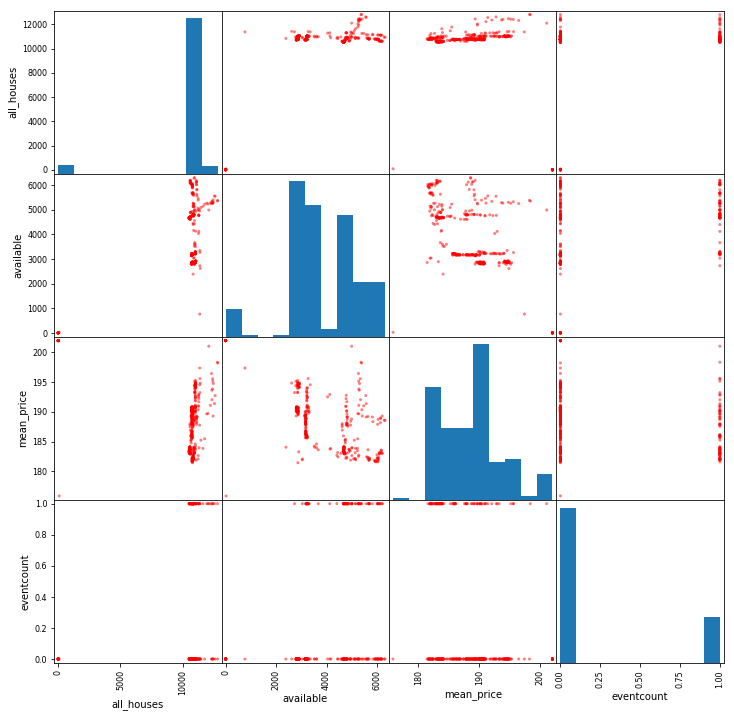

In [10]:
scattercols = ['all_houses', 'available', 'mean_price', 'eventcount']
axs = pd.plotting.scatter_matrix(dfDate[scattercols], figsize=(12,12), c='red')

Interactive visualization

In [11]:
start_date = datetime(2019, 9, 14)
end_date = datetime(2020, 6, 1)
dates = pd.date_range(start_date, end_date, freq='D')
options=[(date.strftime(' %d %b %Y '), date) for date in dates]


selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=(0, len(options)-1),
    description='Dates',
    orientation='horizontal',
    layout={'width': '600px'}
)
zoom_selection = widgets.Dropdown(
    options=[1, 1.25, 1.5, 1.75],
    value=1,
    description='Zoom'
)
date_selection = widgets.Dropdown(
    options=['Allday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    value='Allday',
    description='Weekday:',
)

draw_selection = widgets.RadioButtons(
    options=['All', 'EventsAndNot'],
    value='All',
    description='Graphs:',
)
type_selection = widgets.RadioButtons(
    options=['line', 'bar'],
    value='line',
    description='Graph type'
    )
value_selection = widgets.RadioButtons(
    options=['mean_price', 'mean_avail'],
    value='mean_price',
    description='Variable'
)


In [12]:
def linePlot(dateRange, day, lines, yZoom, var):
    if var == 'mean_price':
        y = 175
    else:
        y = 0.4
    startD = dateRange[0]
    endD = dateRange[1]
    dfD = dfDate[(dfDate['date'] >= startD)]
    dfD = dfD[(dfD['date'] <= endD)]
    fig, ax = plt.subplots(figsize=(20,10))
    
    if day != 'Allday':
        dfD = dfD[(dfD['day'] == day)]
    if lines == 'All':
        plt.plot(dfD['date'],
                 dfD[var],
                 color='purple',
                 label=var)
    else:
        dfE = dfD[(dfD['eventcount'] != 0)]
        dfNe = dfD[(dfD['eventcount'] == 0)]
        plt.plot(dfE['date'],
                 dfE[var],
                 color='blue',
                 label='events')
        plt.plot(dfNe['date'],
                 dfNe[var],
                 color='red',
                 label='noEvents')
        
    ax.set(xlabel="Date",
           ylabel=var)
    zoom = y*(yZoom-1)
    ax.set_ylim([0+zoom,(2*y)-zoom])
    plt.legend()
    
    
def barPlot(dateRange, lines, var):
    startD = dateRange[0]
    endD = dateRange[1]
        
    dfD = dfDate[(dfDate['date'] >= startD)]
    dfD = dfD[(dfD['date'] <= endD)]
    fig, ax = plt.subplots(figsize=(20,10))
    objects = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
    y_pos = np.arange(len(objects))
    if lines == 'All':

        monday = dfD[(dfD['day'] == 'Monday')]
        tuesday = dfD[(dfD['day'] == 'Tuesday')]
        wednesday = dfD[(dfD['day'] == 'Wednesday')]
        thursday = dfD[(dfD['day'] == 'Thursday')]
        friday = dfD[(dfD['day'] == 'Friday')]
        saturday = dfD[(dfD['day'] == 'Saturday')]
        sunday = dfD[(dfD['day'] == 'Sunday')]
        performance = [monday[var].mean(), 
                       tuesday[var].mean(), 
                       wednesday[var].mean(), 
                       thursday[var].mean(), 
                       friday[var].mean(), 
                       saturday[var].mean(), 
                       sunday[var].mean()]
        plt.bar(y_pos,
                performance,
                align='center',
                label='All')
    else:
        dfE = dfD[(dfD['eventcount'] != 0)]
        dfNe = dfD[(dfD['eventcount'] == 0)]
        
        monday1 = dfE[(dfE['day'] == 'Monday')]
        tuesday1 = dfE[(dfE['day'] == 'Tuesday')]
        wednesday1 = dfE[(dfE['day'] == 'Wednesday')]
        thursday1 = dfE[(dfE['day'] == 'Thursday')]
        friday1 = dfE[(dfE['day'] == 'Friday')]
        saturday1 = dfE[(dfE['day'] == 'Saturday')]
        sunday1 = dfE[(dfE['day'] == 'Sunday')]
        
        performance1 = [monday1[var].mean(), 
                       tuesday1[var].mean(), 
                       wednesday1[var].mean(), 
                       thursday1[var].mean(), 
                       friday1[var].mean(), 
                       saturday1[var].mean(), 
                       sunday1[var].mean()]
        
        monday2 = dfNe[(dfNe['day'] == 'Monday')]
        tuesday2 = dfNe[(dfNe['day'] == 'Tuesday')]
        wednesday2 = dfNe[(dfNe['day'] == 'Wednesday')]
        thursday2 = dfNe[(dfNe['day'] == 'Thursday')]
        friday2 = dfNe[(dfNe['day'] == 'Friday')]
        saturday2 = dfNe[(dfNe['day'] == 'Saturday')]
        sunday2 = dfNe[(dfNe['day'] == 'Sunday')]

        performance2 = [monday2[var].mean(), 
                       tuesday2[var].mean(), 
                       wednesday2[var].mean(), 
                       thursday2[var].mean(), 
                       friday2[var].mean(), 
                       saturday2[var].mean(), 
                       sunday2[var].mean()]
        plt.bar(y_pos-0.2,
                performance1,
                width=0.4,
                align='center',
                label='Events')
        plt.bar(y_pos+0.2,
                performance2,
                width=0.4,
                align='center',
                label='noEvents')
    plt.xticks(y_pos, objects)
    plt.ylabel(var)
    plt.legend()
    
def selector(grType, dateRange, day, lines, yZoom, var):
    if grType == 'line':
        linePlot(dateRange, day, lines, yZoom, var)
    else:
        barPlot(dateRange, lines, var)
        

widgets.interact(  
    selector,
    grType = type_selection,
    dateRange=selection_range_slider,
    yZoom = zoom_selection,
    day = date_selection,
    lines = draw_selection,
    var = value_selection
);



interactive(children=(RadioButtons(description='Graph type', options=('line', 'bar'), value='line'), Selection…

Multivariate regression

got error 1.97
got error 2.15
got error 2.29
got error 2.03
got error 2.03
got error 2.36


Text(0, 0.5, 'Median Absolute Error')

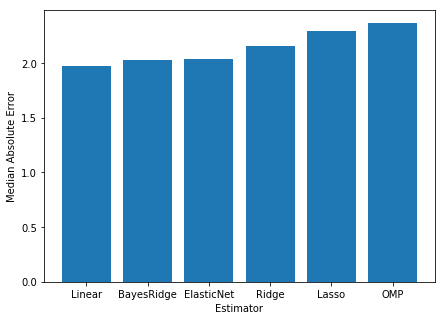

In [13]:
dfData = dfDate.drop(columns=['date', 'day', 'sport_event', 'max_price', 'min_price'])
rs = 1
ests = [linear_model.LinearRegression(), linear_model.Ridge(), linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])
X_train, X_test, y_train, y_test = train_test_split(dfData.drop(['mean_price'], axis=1),
                                                    dfData.mean_price, test_size=0.2, random_state=20)

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    print ("got error %0.2f" % this_err)
    errvals = np.append(errvals, this_err)
pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

In [14]:
print(dfData.corr())

             all_houses  available  mean_avail  mean_price  eventcount  \
all_houses     1.000000   0.625780   -0.237552   -0.480276    0.142140   
available      0.625780   1.000000    0.603374   -0.668286    0.357036   
mean_avail    -0.237552   0.603374    1.000000   -0.298873    0.300743   
mean_price    -0.480276  -0.668286   -0.298873    1.000000   -0.250631   
eventcount     0.142140   0.357036    0.300743   -0.250631    1.000000   
weekdaynumb    0.050557   0.001685   -0.050567    0.184744   -0.033478   

             weekdaynumb  
all_houses      0.050557  
available       0.001685  
mean_avail     -0.050567  
mean_price      0.184744  
eventcount     -0.033478  
weekdaynumb     1.000000  


In [15]:
n_est = 2500
tuned_parameters = {
    "n_estimators": [ n_est],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1.0 ],
    "loss" : [ 'ls', 'lad' ]
}
gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Text(0, 0.5, 'Least Absolute Deviation')

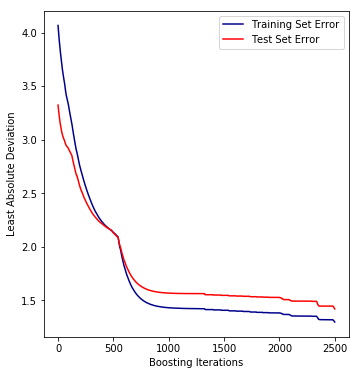

In [16]:
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

Text(0.5, 1.0, 'Variable Importance')

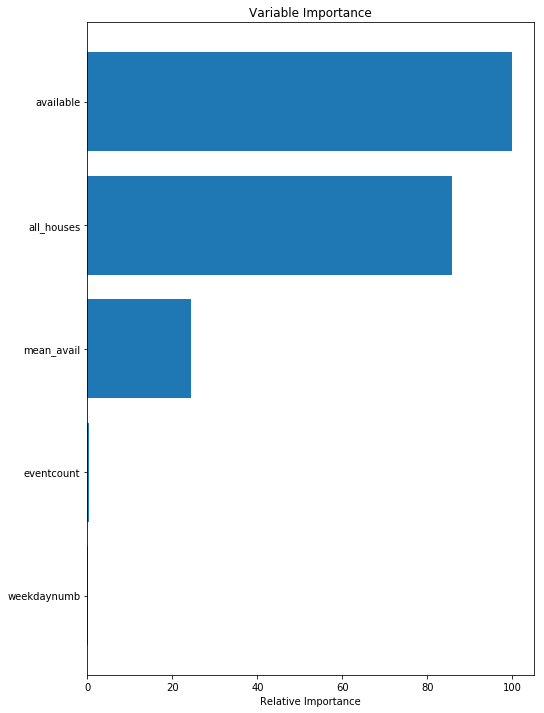

In [17]:
feature_importance = clf.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')